In [1]:

######## snakemake preamble start (automatically inserted, do not edit) ########
import sys; sys.path.extend(['/project2/gilad/bjf79_project1/envs/main/lib/python3.9/site-packages', '/project2/yangili1/bjf79/ChromatinSplicingQTLs/code/notebooks']); import pickle; snakemake = pickle.loads(b'\x80\x04\x95\x9f\x05\x00\x00\x00\x00\x00\x00\x8c\x10snakemake.script\x94\x8c\tSnakemake\x94\x93\x94)\x81\x94}\x94(\x8c\x05input\x94\x8c\x0csnakemake.io\x94\x8c\nInputFiles\x94\x93\x94)\x81\x94(\x8c=QTLs/QTLTools/polyA.Splicing/PermutationPass.FDR_Added.txt.gz\x94\x8c?QTLs/QTLTools/polyA.Splicing/OnlyFirstReps.sorted.qqnorm.bed.gz\x94\x8c>QTLs/QTLTools/Expression.Splicing/Genotypes/WholeGenome.vcf.gz\x94e}\x94(\x8c\x06_names\x94}\x94\x8c\x12_allowed_overrides\x94]\x94(\x8c\x05index\x94\x8c\x04sort\x94eh\x12\x8c\tfunctools\x94\x8c\x07partial\x94\x93\x94h\x06\x8c\x19Namedlist._used_attribute\x94\x93\x94\x85\x94R\x94(h\x18)}\x94\x8c\x05_name\x94h\x12sNt\x94bh\x13h\x16h\x18\x85\x94R\x94(h\x18)}\x94h\x1ch\x13sNt\x94bub\x8c\x06output\x94h\x06\x8c\x0bOutputFiles\x94\x93\x94)\x81\x94\x8cOQTLs/QTLTools/polyA.Splicing/PermutationPass.FDR_Added.SS_SNPs.Annotated.txt.gz\x94a}\x94(h\x0e}\x94h\x10]\x94(h\x12h\x13eh\x12h\x16h\x18\x85\x94R\x94(h\x18)}\x94h\x1ch\x12sNt\x94bh\x13h\x16h\x18\x85\x94R\x94(h\x18)}\x94h\x1ch\x13sNt\x94bub\x8c\x06params\x94h\x06\x8c\x06Params\x94\x93\x94)\x81\x94}\x94(h\x0e}\x94h\x10]\x94(h\x12h\x13eh\x12h\x16h\x18\x85\x94R\x94(h\x18)}\x94h\x1ch\x12sNt\x94bh\x13h\x16h\x18\x85\x94R\x94(h\x18)}\x94h\x1ch\x13sNt\x94bub\x8c\twildcards\x94h\x06\x8c\tWildcards\x94\x93\x94)\x81\x94}\x94(h\x0e}\x94h\x10]\x94(h\x12h\x13eh\x12h\x16h\x18\x85\x94R\x94(h\x18)}\x94h\x1ch\x12sNt\x94bh\x13h\x16h\x18\x85\x94R\x94(h\x18)}\x94h\x1ch\x13sNt\x94bub\x8c\x07threads\x94K\x01\x8c\tresources\x94h\x06\x8c\tResources\x94\x93\x94)\x81\x94(K\x01K\x01e}\x94(h\x0e}\x94(\x8c\x06_cores\x94K\x00N\x86\x94\x8c\x06_nodes\x94K\x01N\x86\x94uh\x10]\x94(h\x12h\x13eh\x12h\x16h\x18\x85\x94R\x94(h\x18)}\x94h\x1ch\x12sNt\x94bh\x13h\x16h\x18\x85\x94R\x94(h\x18)}\x94h\x1ch\x13sNt\x94bhWK\x01hYK\x01ub\x8c\x03log\x94h\x06\x8c\x03Log\x94\x93\x94)\x81\x94\x8c4../docs/20210921_CountSpliceSiteSNPsInSQTLs.py.ipynb\x94a}\x94(h\x0e}\x94\x8c\x08notebook\x94K\x00N\x86\x94sh\x10]\x94(h\x12h\x13eh\x12h\x16h\x18\x85\x94R\x94(h\x18)}\x94h\x1ch\x12sNt\x94bh\x13h\x16h\x18\x85\x94R\x94(h\x18)}\x94h\x1ch\x13sNt\x94bhkhhub\x8c\x06config\x94}\x94(\x8c\x07scratch\x94\x8c\x17/scratch/midway2/bjf79/\x94\x8c\x07samples\x94\x8c\x0bsamples.tsv\x94\x8c\naspera_key\x94\x8c8/home/bjf79/.aspera/connect/etc/asperaweb_id_dsa.openssh\x94\x8c\x0bsQTL_chunks\x94M\xe8\x03u\x8c\x04rule\x94\x8c\x1fCount_sQTLs_with_SpliceSiteSNPs\x94\x8c\x0fbench_iteration\x94N\x8c\tscriptdir\x94\x8c=/project2/yangili1/bjf79/ChromatinSplicingQTLs/code/notebooks\x94ub.'); from snakemake.logging import logger; logger.printshellcmds = True; import os; os.chdir('/project2/yangili1/bjf79/ChromatinSplicingQTLs/code');
######## snakemake preamble end #########


# Intro

In this notebook, I was planning to better understand how many spliceQTLs are due to SNPs in core splice sites (5'ss or 3'ss). As a simple first pass at this, I will look at the QTLtools permutation pass output in which I performed permutation pass on leafcutter intron phenotypes, using the smallest P-value amongst any intron within a cluster as the test statistic. Therefore, this QTLtools output has a single nominal P value (and single FDR corrected Qvalue) for each cluster of introns. So the way I plan to go about this, is to check for each cluster, check if any of the introns in the cluster overlap splice sites, then look for a pattern between the cluster P-value and whether any of the cluster's introns contain a splice site.

Now onto the code...

## import libs


In [2]:
import os

I think jupyter notebook will open a notebook and change to the parent directory of the notebook while you are editing. But I want this notebook to execute as if it will be executed in a snakemake, so while I am editing in jupyter notebook, I will change to that snakemake's parent directory, and be sure to comment out that change directory command

In [3]:
# os.chdir("../")
print(os.getcwd())

import pandas as pd
import gzip
import vcf
from plotnine import *

/project2/yangili1/bjf79/ChromatinSplicingQTLs/code


## helper functions

In [4]:
def count_iterable(i):
    return sum(1 for e in i)

def Count_SNPs_Around_Pos(vcf_reader, chrom, pos, upstream_bp, downstream_bp, strand="+"):
    """
    for a vcf_reader object, return an integer of the number of variants that intersect a window
    defined by a upstream_bp (normally negative), and a downstream_bp (normally positive),
    relative to a pos on a chrom. Reverse upstream_bp and downstream_bp if strand not +
    """
    if strand=="+":
        return count_iterable(vcf_reader.fetch(chrom, pos+upstream_bp, pos+downstream_bp))
    else:
        return count_iterable(vcf_reader.fetch(chrom, pos-downstream_bp, pos-upstream_bp))

def PickArg2IfStrandNegative(arg1, arg2, strand):
    if strand == "+":
        return arg1
    else:
        return arg2

## read clusters

Read introns from QTLtools bedgz input, which has intron coordinates and cluster ID for each intron. Then read in QTLtools permutation test output (permutation tested grouped by cluster) to get Q value for each cluster being a QTL.

In [5]:
splicing_bedgz_f = "QTLs/QTLTools/polyA.Splicing/OnlyFirstReps.sorted.qqnorm.bed.gz"
Clusters = pd.read_csv(splicing_bedgz_f, delimiter='\t', usecols=range(0,5))


splicing_QTL_permutation_test_f = "QTLs/QTLTools/polyA.Splicing/PermutationPass.FDR_Added.txt.gz"
Cluster_sig = pd.read_csv(splicing_QTL_permutation_test_f, delimiter=' ', usecols=['grp_id', 'q'])


Merged = pd.merge(Clusters, Cluster_sig, left_on="gid", right_on="grp_id", how="left")
Merged

,#Chr,start,end,pid,gid,grp_id,q
0,chr1,15947,16607,1:15947:16607:clu_1_-,chr1_clu_1_-,chr1_clu_1_-,0.51821
1,chr1,16310,16607,1:16310:16607:clu_1_-,chr1_clu_1_-,chr1_clu_1_-,0.51821
2,chr1,17055,17915,1:17055:17915:clu_2_-,chr1_clu_2_-,chr1_clu_2_-,0.79293
3,chr1,17055,17233,1:17055:17233:clu_2_-,chr1_clu_2_-,chr1_clu_2_-,0.79293
4,chr1,17368,17915,1:17368:17915:clu_2_-,chr1_clu_2_-,chr1_clu_2_-,0.79293
...,...,...,...,...,...,...,...
143404,chr9,137798914,137800880,9:137798914:137800880:clu_20895_+,chr9_clu_20895_+,chr9_clu_20895_+,0.76432
143405,chr9,137800575,137800880,9:137800575:137800880:clu_20895_+,chr9_clu_20895_+,chr9_clu_20895_+,0.76432
143406,chr9,137800984,137802409,9:137800984:137802409:clu_20894_+,chr9_clu_20894_+,chr9_clu_20894_+,0.43322
143407,chr9,137800984,137802857,9:137800984:137802857:clu_20894_+,chr9_clu_20894_+,chr9_clu_20894_+,0.43322


Now, let's add a column for the donor position (5' intron boundary), and the acceptor (3' intron boundary), which will have to take strandedness into account.

In [6]:
Merged['strand']=Merged['pid'].str[-1:]
Merged['DonorPos']=Merged.apply(lambda x: PickArg2IfStrandNegative(x['start'], x['end']-1, x['strand']), axis=1)
Merged['AcceptorPos']=Merged.apply(lambda x: PickArg2IfStrandNegative(x['end']-1, x['start'], x['strand']), axis=1)

Merged

,#Chr,start,end,pid,gid,grp_id,q,strand,DonorPos,AcceptorPos
0,chr1,15947,16607,1:15947:16607:clu_1_-,chr1_clu_1_-,chr1_clu_1_-,0.51821,-,16606,15947
1,chr1,16310,16607,1:16310:16607:clu_1_-,chr1_clu_1_-,chr1_clu_1_-,0.51821,-,16606,16310
2,chr1,17055,17915,1:17055:17915:clu_2_-,chr1_clu_2_-,chr1_clu_2_-,0.79293,-,17914,17055
3,chr1,17055,17233,1:17055:17233:clu_2_-,chr1_clu_2_-,chr1_clu_2_-,0.79293,-,17232,17055
4,chr1,17368,17915,1:17368:17915:clu_2_-,chr1_clu_2_-,chr1_clu_2_-,0.79293,-,17914,17368
...,...,...,...,...,...,...,...,...,...,...
143404,chr9,137798914,137800880,9:137798914:137800880:clu_20895_+,chr9_clu_20895_+,chr9_clu_20895_+,0.76432,+,137798914,137800879
143405,chr9,137800575,137800880,9:137800575:137800880:clu_20895_+,chr9_clu_20895_+,chr9_clu_20895_+,0.76432,+,137800575,137800879
143406,chr9,137800984,137802409,9:137800984:137802409:clu_20894_+,chr9_clu_20894_+,chr9_clu_20894_+,0.43322,+,137800984,137802408
143407,chr9,137800984,137802857,9:137800984:137802857:clu_20894_+,chr9_clu_20894_+,chr9_clu_20894_+,0.43322,+,137800984,137802856


Now, I want to classify the introns by whether or not there is a test SNP near the intron boundaries... I did some careful checking of my code with the help of visualizing SNPs and splice sites in IGV, to check that this counting works as expected with regards to both plus and minus strand introns at both 5'ss and 3'ss SNPs.

In [7]:
vcf_reader = vcf.Reader(filename='QTLs/QTLTools/Expression.Splicing/Genotypes/WholeGenome.vcf.gz')

#From -1 to 5 pos relative to donor GT: [0]G[1]T
Merged['DonorSnpCount'] = Merged.apply(lambda x: Count_SNPs_Around_Pos(vcf_reader, x['#Chr'], x['DonorPos'], -1, 5, strand=x['strand']), axis=1)

In [8]:
# From -3 position to 0 (YAG) 3'ss
Merged['AcceptorSnpCount'] = Merged.apply(lambda x: Count_SNPs_Around_Pos(vcf_reader, x['#Chr'], x['AcceptorPos'], -3, 0, strand=x['strand']), axis=1)


Now make a column to categorize introns as having SNP in splice site or not.

In [9]:
Merged['SNP_in_SS'] = (Merged['AcceptorSnpCount'] + Merged['DonorSnpCount']) > 0

How many introns SNPs overlapping the splice sites?

In [10]:
sum(Merged['SNP_in_SS'])

2982

Now let's plot how many sQTLs have splice site SNPs..

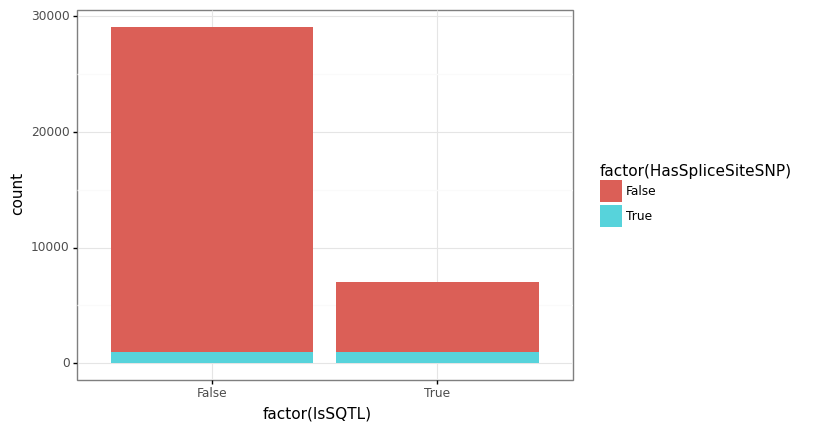

<ggplot: (8778658572783)>

In [11]:
ToPlot = (Merged.filter(['q', 'gid', 'SNP_in_SS'])
    .groupby(['gid', 'q'])
    .agg({"SNP_in_SS": "sum"}))

ToPlot = ToPlot.reset_index()


ToPlot['IsSQTL'] = ToPlot['q'] < 0.1
ToPlot['HasSpliceSiteSNP'] = ToPlot['SNP_in_SS'] > 0



(ggplot(ToPlot, aes(x='factor(IsSQTL)', fill='factor(HasSpliceSiteSNP)'))
 + geom_bar()
 + theme_bw())

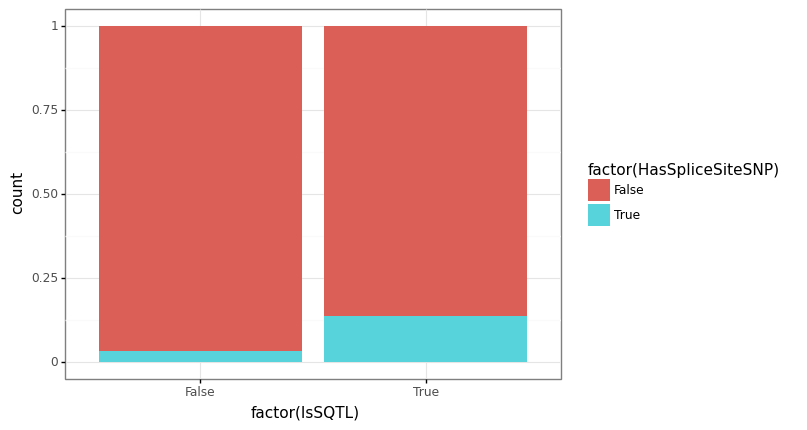

<ggplot: (-9223363258200113534)>

In [12]:
(ggplot(ToPlot, aes(x='factor(IsSQTL)', fill='factor(HasSpliceSiteSNP)'))
 + geom_bar(position="fill")
 + theme_bw())

Finally, let's consider writing out the pertinent results, so I possibly replot in R or something, and also test having output files from my notebook that snakemake can track

In [13]:
Merged.to_csv("QTLs/QTLTools/polyA.Splicing/PermutationPass.FDR_Added.SS_SNPs.Annotated.txt.gz", sep="\t", index=False)